This notebook works through the workflow to go from an orthomosaic image of a forest area to species wise similarity comparison of different trees.

The input to this example is the orthomosaic from Sao Paulo obtained from a drone experiment. 

The workflow is as follows:

![Alt text](image.png)

Step 1: Load Image

In [13]:
import rioxarray
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
data_image = Path('inputs/area_recortada_mosaico.tif')
image_uav = rioxarray.open_rasterio(data_image).isel(band=range(3))

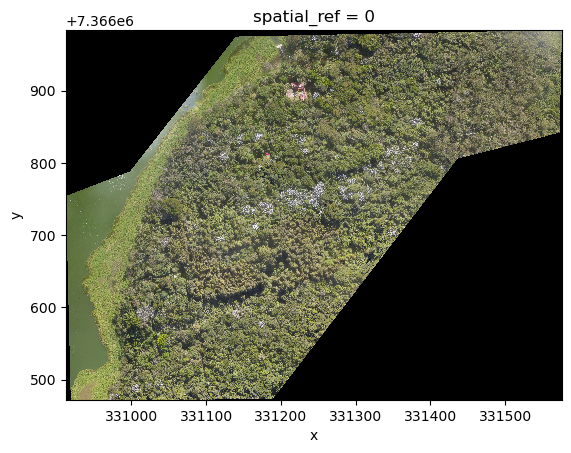

In [16]:
image_uav.plot.imshow()

Step 2: Create crops of large image to focus on particular area

In [30]:
from deepforest_exp import make_crops

# Define crops by tif coordinates
crop_centers = [(331_166,7366_865)]
crop_sizes = 100

img_crops = make_crops(image_uav, crop_centers, crop_sizes)

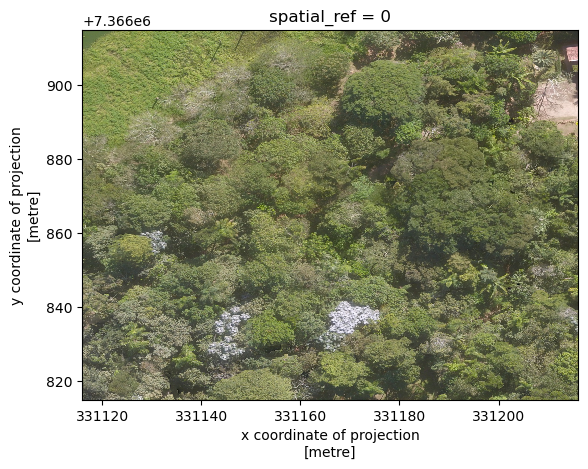

In [31]:
img_crops[0].plot.imshow()

Step 3: Perform tree crown detection using deep forest

In [32]:
# Predict all crops with one set of parameters
from deepforest_exp import predict_crops

tile_size = 500
overlap_ratio = 0.45

gdf_prediction = predict_crops(img_crops, tile_size, overlap_ratio)

Reading config file: /home/cpranav93/miniconda3/envs/xai4geo/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


/home/cpranav93/miniconda3/envs/xai4geo/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cpranav93/miniconda3/envs/xai4geo/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NEON.pt: 129MB [00:08, 15.9MB/s]                              


Model was downloaded and saved to /home/cpranav93/miniconda3/envs/xai4geo/lib/python3.11/site-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


100%|██████████| 25/25 [01:20<00:00,  3.23s/it]


759 predictions in overlapping windows, applying non-max supression
308 predictions kept after non-max suppression


In [33]:
gdf_prediction

,label,score,geometry
0,Tree,0.651552,"POLYGON ((331179.887 7366858.753, 331179.887 7..."
1,Tree,0.582576,"POLYGON ((331201.845 7366899.669, 331201.845 7..."
2,Tree,0.547769,"POLYGON ((331178.045 7366841.023, 331178.045 7..."
3,Tree,0.535160,"POLYGON ((331153.700 7366868.028, 331153.700 7..."
4,Tree,0.529455,"POLYGON ((331129.492 7366858.753, 331129.492 7..."
...,...,...,...
303,Tree,0.108409,"POLYGON ((331187.456 7366816.542, 331187.456 7..."
304,Tree,0.107716,"POLYGON ((331161.815 7366864.413, 331161.815 7..."
305,Tree,0.106481,"POLYGON ((331154.860 7366842.933, 331154.860 7..."
306,Tree,0.102669,"POLYGON ((331138.562 7366877.302, 331138.562 7..."


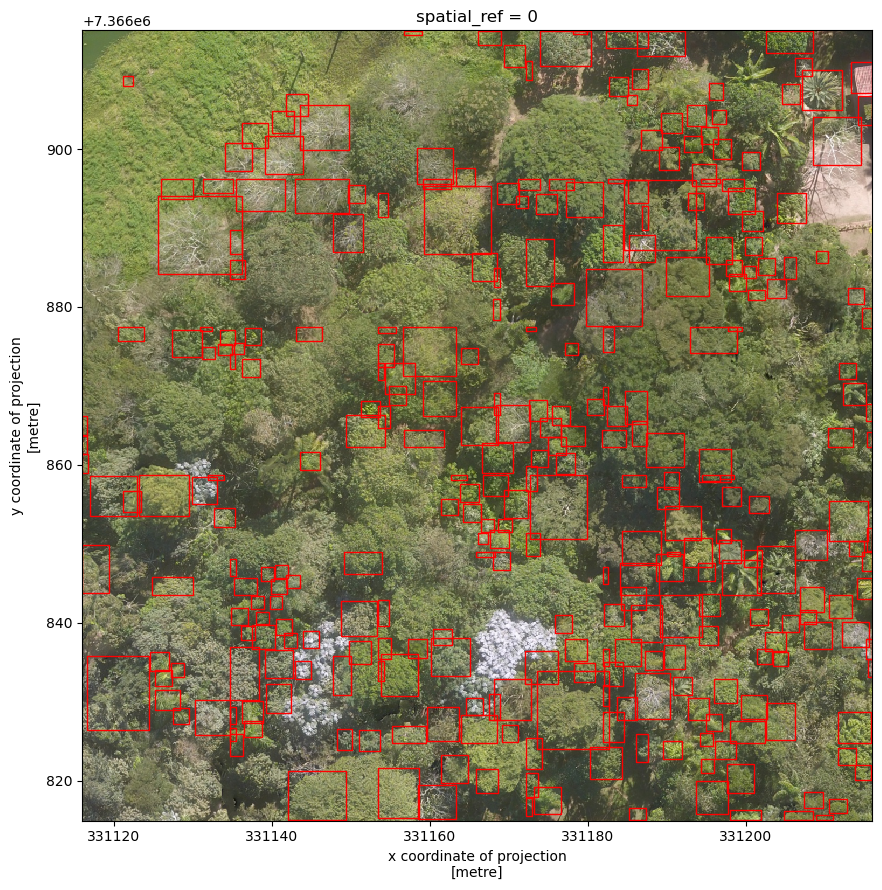

In [47]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 9)
for img in img_crops:
    xmin, ymin, xmax, ymax = img.rio.bounds()
    predicts = gdf_prediction.cx[xmin:xmax, ymin:ymax]
    img.plot.imshow(ax=axes)
    predicts.plot(ax=axes, facecolor="none", edgecolor="red")
    ax.set_aspect('equal', adjustable='box')
fig.tight_layout()

Step 4: Extract individual trees from detected objects

In [53]:
from tree_dataset import TreeDataset
import geopandas
import numpy as np

We are going to read the bounding boxes from pre-provided file

In [54]:
gdf_original = geopandas.read_file('inputs/labels_square.shp')
classes = np.zeros(len(gdf_original))

In [105]:
tree_dataset = TreeDataset(
    rgbs=[img_crops[0]],
    classes=classes,  # deep forest does not return classes 
    bboxes=gdf_prediction['geometry'],
    min_pixel_size=0,
    max_pixel_size=100,
    pixel_size=100,
    min_sample_size=1
)
ids, y_test, X_test = tree_dataset.get_cutouts()

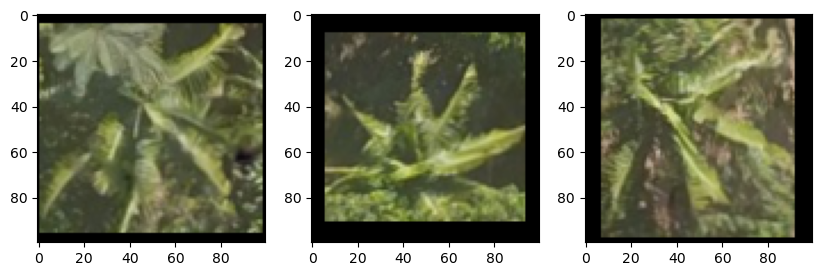

In [82]:
fig = plt.figure(figsize=(10, 15))
for i in range(X_test.shape[0]):
    sub = fig.add_subplot(1, X_test.shape[0], i+1)
    plt.imshow(X_test[i])  

Step 5: Load siamese model

In [89]:
import tensorflow as tf
from tensorflow.keras import backend as k

In [90]:
siamese_model = tf.keras.models.load_model('inputs/siamese_model.keras')

Step 6: Combine training and test dataset.

Load samples from training data-set. This is preprocessed and available.

In [100]:
data = np.load('inputs/class_sample.npz')
X = data['X_sample']
y = data['y_sample']
nclasses = len(np.unique(y))

In [106]:
X_test = X_test/255
y_test[:] = len(np.unique(y))

In [120]:
# Append the training and test image pairs together
X_tot = np.append(X, X_test, axis = 0)
y_tot = np.append(y, y_test, axis = 0)

In [122]:
X.shape

(3, 100, 100, 3)

Step 7: Generate image pairs

In [136]:
def generate_test_image_pairs(X, y, test_image):
    pair_images = []
    for i in range(X.shape[0]):
        pair_images.append((test_image, X[i]))
    return np.array(pair_images)

In [139]:
test_image_pairs = generate_test_image_pairs(X_tot, y_tot, X_tot[-2])

Step 8. Perform prediction using siamese model

1/1 [==============================] - 0s 34ms/step


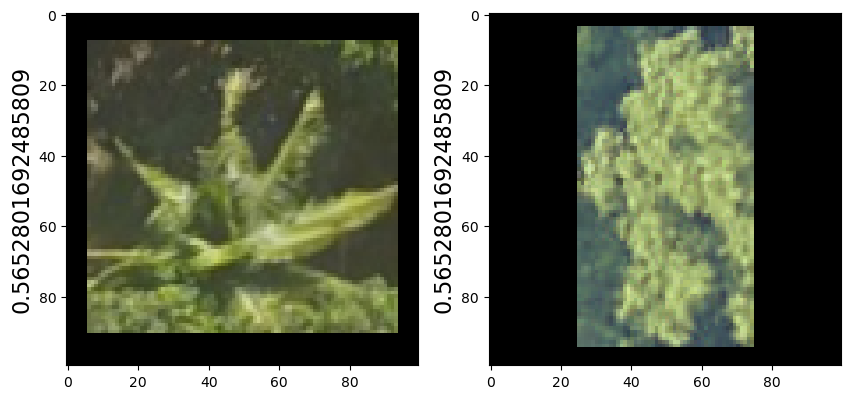

1/1 [==============================] - 0s 43ms/step


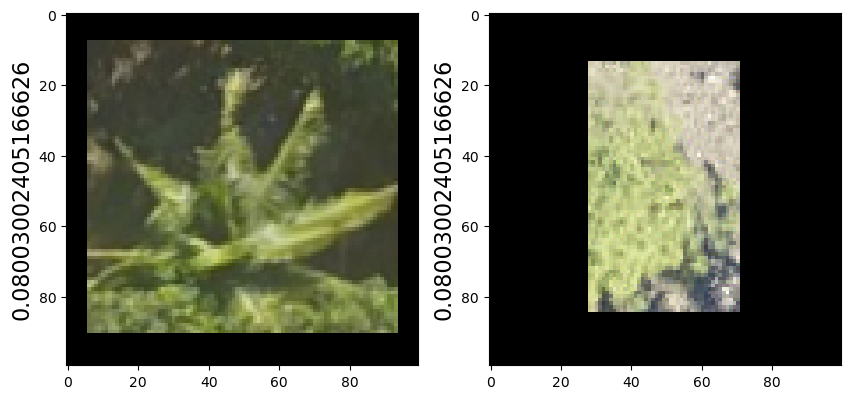

1/1 [==============================] - 0s 39ms/step


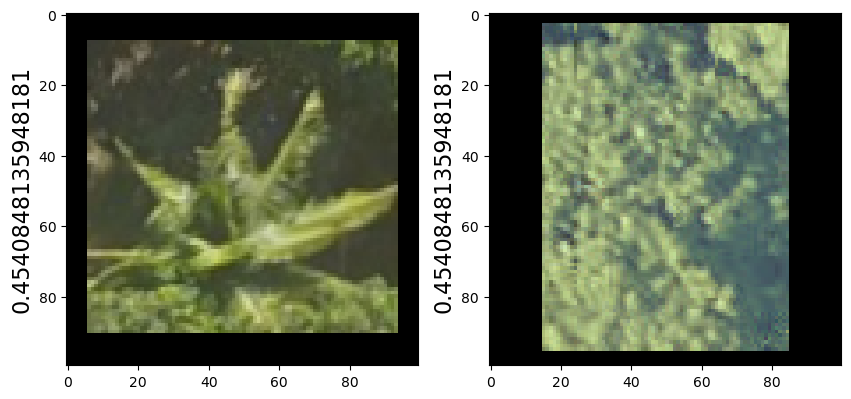

1/1 [==============================] - 0s 46ms/step


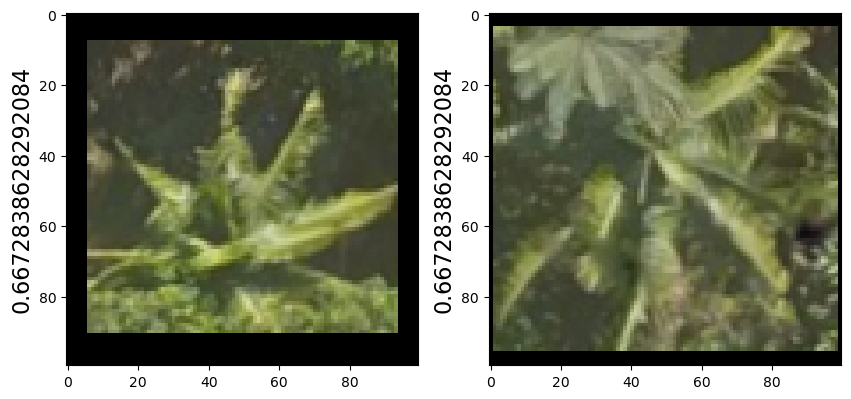

1/1 [==============================] - 0s 41ms/step


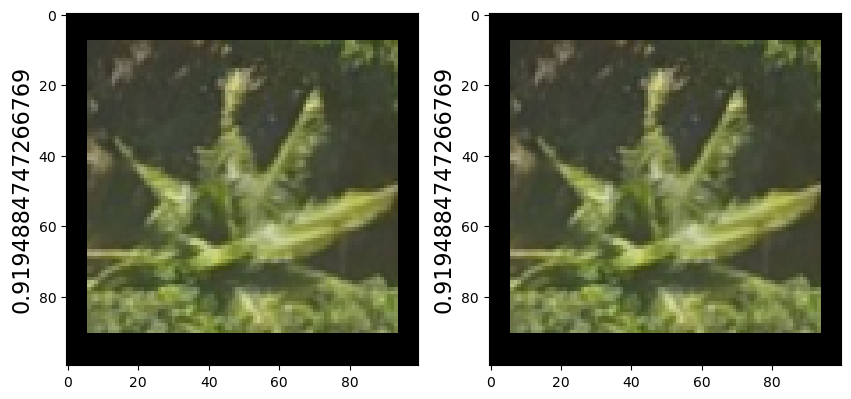

1/1 [==============================] - 0s 36ms/step


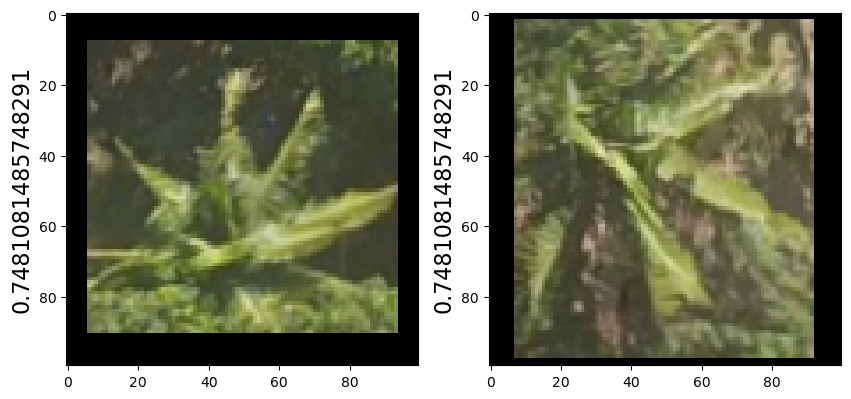

array([0.43471983, 0.91996998, 0.54591519, 0.33271614, 0.08051153,
       0.25189185])

In [140]:
prediction = np.zeros(test_image_pairs.shape[0])
for index, pair in enumerate(test_image_pairs):
    pair_image1 = np.expand_dims(pair[0], axis=-1)
    pair_image1 = np.expand_dims(pair_image1, axis=0)
    pair_image2 = np.expand_dims(pair[1], axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction[index] = siamese_model.predict([pair_image1, pair_image2])[0][0]

    fig = plt.figure(figsize=(10, 15))
    sub = fig.add_subplot(1, 2, 1)
    plt.imshow(pair[0])
    sub.set_ylabel((1-prediction[index]), fontsize=16)
    sub = fig.add_subplot(1, 2, 2)
    plt.imshow(pair[1])
    sub.set_ylabel((1-prediction[index]), fontsize=16)
    plt.show()
prediction